<a href="https://colab.research.google.com/github/Laimo64/Laimo64/blob/main/AI_cw_full_dataset_000005.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!gdown --fuzzy https://drive.google.com/file/d/1eSU-or72yvc3btOhfLO-edux5VBe_TrX/view?usp=sharing

Downloading...
From (original): https://drive.google.com/uc?id=1eSU-or72yvc3btOhfLO-edux5VBe_TrX
From (redirected): https://drive.google.com/uc?id=1eSU-or72yvc3btOhfLO-edux5VBe_TrX&confirm=t&uuid=ccf449d8-0bb7-4ed8-afe1-4ba6861a804a
To: /content/brain.zip
100% 4.97G/4.97G [01:49<00:00, 45.2MB/s]


In [ ]:
!unzip -q brain.zip

Dataloader (include resize)

In [ ]:
import os
import nibabel as nib
import numpy as np
import torch
from torch.utils.data import Dataset
import torch.nn.functional as F
from scipy.ndimage import zoom

class MRCTDataset(Dataset):
    def __init__(self, data_dir, target_size=(128, 128, 128)):  ###### target_size=(96, 96, 96)改128試試
        """
        初始化數據集
        Args:
            data_dir (str): MRI 和 CT 數據的根目錄。
            target_size (tuple): 將 MRI 和 CT 影像調整為的固定尺寸。
        """
        self.data_dir = data_dir
        self.target_size = target_size
        self.samples = [
            os.path.join(root)
            for root, _, files in os.walk(data_dir)
            if "mr.nii.gz" in files and "ct.nii.gz" in files
        ]

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        """
        根據索引返回一組 MR 和 CT 影像。
        Args:
            idx (int): 數據的索引。
        Returns:
            Tuple[torch.Tensor, torch.Tensor]: MR 和 CT 的張量形式。
        """
        sample_path = self.samples[idx]

        # 加載 MRI 和 CT 影像
        mr = nib.load(os.path.join(sample_path, "mr.nii.gz")).get_fdata()
        ct = nib.load(os.path.join(sample_path, "ct.nii.gz")).get_fdata()

        # Z-score 標準化
        mr = self._normalize(mr)
        ct = self._normalize(ct)

        # 調整或填充影像大小
        mr = self._resize_or_pad(mr, self.target_size)
        ct = self._resize_or_pad(ct, self.target_size)

        # 轉換為 PyTorch 張量並增加通道維度
        mr = torch.tensor(mr, dtype=torch.float32).unsqueeze(0)  # (1, D, H, W)
        ct = torch.tensor(ct, dtype=torch.float32).unsqueeze(0)  # (1, D, H, W)

        return mr, ct

    def _normalize(self, image):
        """
        Z-score 標準化影像數據。
        Args:
            image (np.ndarray): 輸入影像。
        Returns:
            np.ndarray: 標準化的影像。
        """
        if np.std(image) != 0:
            return (image - np.mean(image)) / np.std(image)
        else:
            return image

    def _resize_or_pad(self, image, desired_shape):
        """
        調整影像大小或填充至固定大小。
        Args:
            image (np.ndarray): 輸入影像。
            desired_shape (tuple): 目標大小。
        Returns:
            np.ndarray: 調整或填充後的影像。
        """
        current_shape = image.shape
        scale = [d / c for d, c in zip(desired_shape, current_shape)]
        resized_image = zoom(image, scale, order=1)  # 調整大小

        # 填充影像至目標大小
        padded_image = np.zeros(desired_shape, dtype=resized_image.dtype)
        pad_slices = tuple(slice(0, min(dim, resized_image.shape[i])) for i, dim in enumerate(desired_shape))
        padded_image[pad_slices] = resized_image[:desired_shape[0], :desired_shape[1], :desired_shape[2]]

        return padded_image


Data Split

In [ ]:
from sklearn.model_selection import train_test_split
import shutil

data_path = "/content/brain"
output_root = "/content/split"  # 輸出目錄

# 創建輸出資料夾
os.makedirs(output_root, exist_ok=True)
os.makedirs(os.path.join(output_root, "train"), exist_ok=True)
os.makedirs(os.path.join(output_root, "validation"), exist_ok=True)
os.makedirs(os.path.join(output_root, "test"), exist_ok=True)

# 獲取所有樣本資料夾名稱
samples = [name for name in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, name))]

# 按照 70:15:15 的比例分割
train_samples, test_samples = train_test_split(samples, test_size=0.3, random_state=42)
validation_samples, test_samples = train_test_split(test_samples, test_size=0.5, random_state=42)

print(f"Total samples: {len(samples)}")
print(f"Train samples: {len(train_samples)}, Validation samples: {len(validation_samples)}, Test samples: {len(test_samples)}")

# 定義拷貝函數
def move_samples(samples, output_dir):
    for sample in samples:
        src_path = os.path.join(data_path, sample)  # 原始路徑
        dst_path = os.path.join(output_dir, sample)  # 目標路徑
        if os.path.exists(dst_path):
            print(f"Sample {sample} already exists in {output_dir}, skipping.")
            continue
        shutil.copytree(src_path, dst_path)  # 拷貝整個資料夾
        # print(f"Moved {sample} to {output_dir}")

# 將樣本移動到各自的資料夾
move_samples(train_samples, os.path.join(output_root, "train"))
move_samples(validation_samples, os.path.join(output_root, "validation"))
move_samples(test_samples, os.path.join(output_root, "test"))

print("Data split and moved successfully!")


Total samples: 181
Train samples: 126, Validation samples: 27, Test samples: 28
Data split and moved successfully!


MESP(Structure)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


# Swin Transformer Block (簡化版，適用於3D)
class SwinTransformerBlock(nn.Module):
    def __init__(self, dim, input_size):
        super(SwinTransformerBlock, self).__init__()
        self.norm = nn.LayerNorm(dim)
        self.fc = nn.Linear(dim, dim)
        self.window_size = input_size // 4  # 分割窗口，根據3D的尺寸調整

    def forward(self, x):
        b, c, d, h, w = x.shape  # 3D 輸入
        x = x.view(b, -1, c)  # 展平為序列
        x = self.norm(x)
        x = self.fc(x)
        return x.view(b, c, d, h, w)  # 還原為 3D

# MSEP 網路
class MSEP(nn.Module):
    def __init__(self):
        super(MSEP, self).__init__()
        # Encoder 部分
        self.encoder = nn.Sequential(
            nn.Conv3d(1, 64, kernel_size=3, stride=1, padding=1),  # 使用3D卷積
            nn.ReLU(),
            nn.Conv3d(64, 128, kernel_size=3, stride=1, padding=1),  # 使用3D卷積
            nn.ReLU()
        )
        # Skip 連接部分 + RDSformer
        self.skip = SwinTransformerBlock(128, input_size=160)
        # Decoder 部分
        self.decoder = nn.Sequential(
            nn.ConvTranspose3d(128, 64, kernel_size=3, stride=1, padding=1),  # 使用3D反卷積
            nn.ReLU(),
            nn.ConvTranspose3d(64, 1, kernel_size=3, stride=1, padding=1)  # 使用3D反卷積
        )

    def forward(self, x):
        enc = self.encoder(x)
        skip = self.skip(enc)  # 加入 skip connection
        dec = self.decoder(skip)
        return dec

# Initialize model
model = MSEP()

# Test the model with dummy data (e.g., [Batch Size, Channel, Depth, Height, Width])
dummy_input = torch.randn(1, 1, 128, 128, 128)  # 假設數據大小是 [1, 1, 128, 128, 128]
output = model(dummy_input)

print("Output shape:", output.shape)  # 應該返回符合預期的 3D 輸出


Output shape: torch.Size([1, 1, 128, 128, 128])


Training & Visualization

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

class EarlyStopping:
    def __init__(self, patience=5, verbose=True, delta=0.00005, path="checkpoint.pt"):
        """
        Args:
            patience (int): 容忍驗證損失未改善的次數 (default: 5)
            verbose (bool): 是否打印相關資訊 (default: False)
            delta (float): 最小改善幅度，只有超過此值才算改善 (default: 0)
            path (str): 模型權重保存路徑 (default: "checkpoint.pt")
        """
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.path = path
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float("inf")

    def __call__(self, val_loss, model):
        # 計算當前得分（驗證損失的負值，因為越小越好）
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        """保存當前模型權重"""
        if self.verbose:
            print(f"Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model...")
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss


def visualize_results(input_image, target_image, predicted_image, epoch, idx):
    """
    視覺化輸入影像、目標影像與預測影像
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # 輸入影像
    axes[0].imshow(input_image[0, 0, :, :, input_image.shape[4] // 2].cpu().detach().numpy(), cmap="gray")
    axes[0].set_title("Input (MR)")
    axes[0].axis("off")

    # 目標影像3
    axes[1].imshow(target_image[0, 0, :, :, target_image.shape[4] // 2].cpu().detach().numpy(), cmap="gray")
    axes[1].set_title("Target (CT)")
    axes[1].axis("off")

    # 預測影像
    axes[2].imshow(predicted_image[0, 0, :, :, predicted_image.shape[4] // 2].cpu().detach().numpy(), cmap="gray")
    axes[2].set_title("Prediction (Generated CT)")
    axes[2].axis("off")

    plt.suptitle(f"Epoch {epoch}, Batch {idx}")
    plt.show()


MR shape: torch.Size([2, 1, 128, 128, 128]), CT shape: torch.Size([2, 1, 128, 128, 128])


Epoch 1/10: 100%|██████████| 63/63 [04:44<00:00,  4.52s/it, loss=0.213]


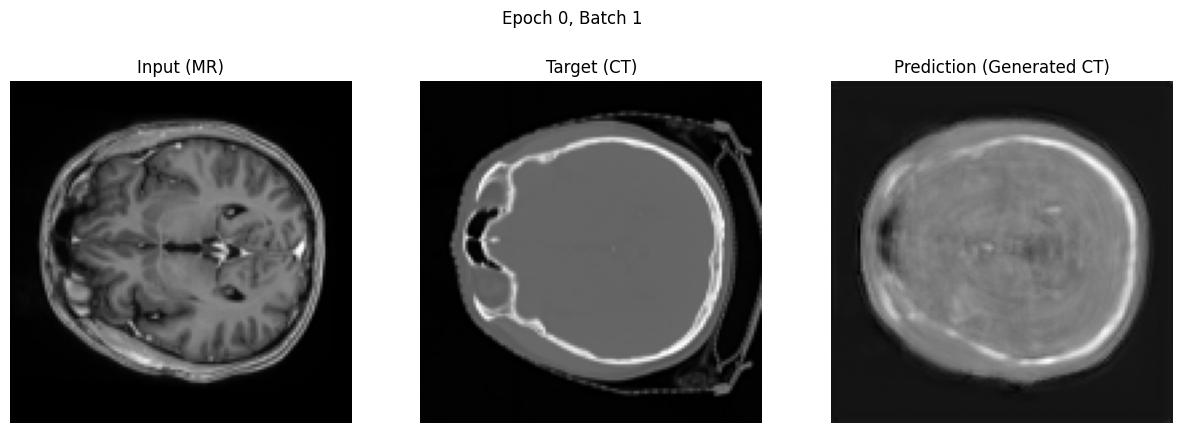

Epoch 1/10, Avg Train Loss: 0.1811774368323977
Epoch 1/10, Avg Validation Loss: 0.17198001274040767
Validation loss decreased (inf --> 2.407720). Saving model...


Epoch 2/10: 100%|██████████| 63/63 [04:50<00:00,  4.62s/it, loss=0.244]


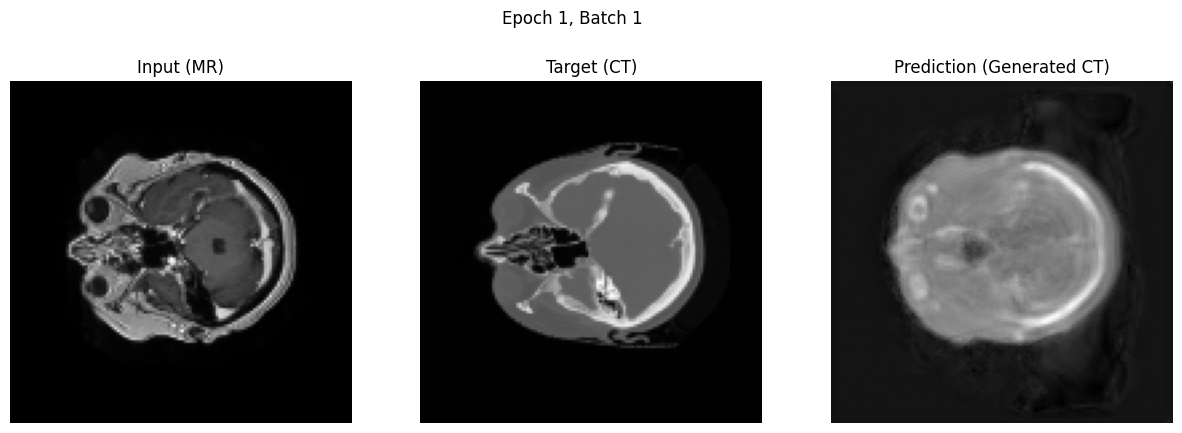

Epoch 2/10, Avg Train Loss: 0.17795956016532957
Epoch 2/10, Avg Validation Loss: 0.17020975585494721
Validation loss decreased (2.407720 --> 2.382937). Saving model...


Epoch 3/10: 100%|██████████| 63/63 [04:50<00:00,  4.62s/it, loss=0.184]


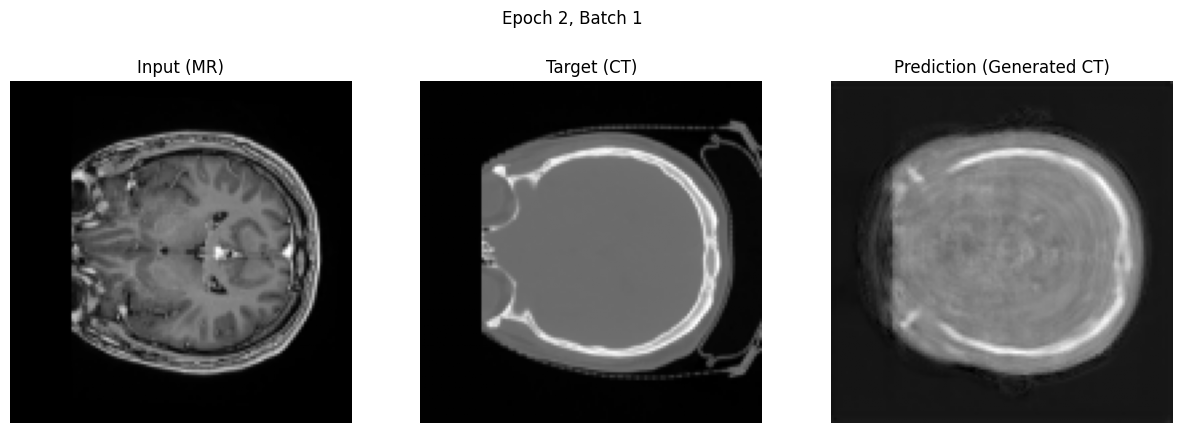

Epoch 3/10, Avg Train Loss: 0.17638262869819762
Epoch 3/10, Avg Validation Loss: 0.16968577355146408
Validation loss decreased (2.382937 --> 2.375601). Saving model...


Epoch 4/10: 100%|██████████| 63/63 [04:51<00:00,  4.62s/it, loss=0.185]


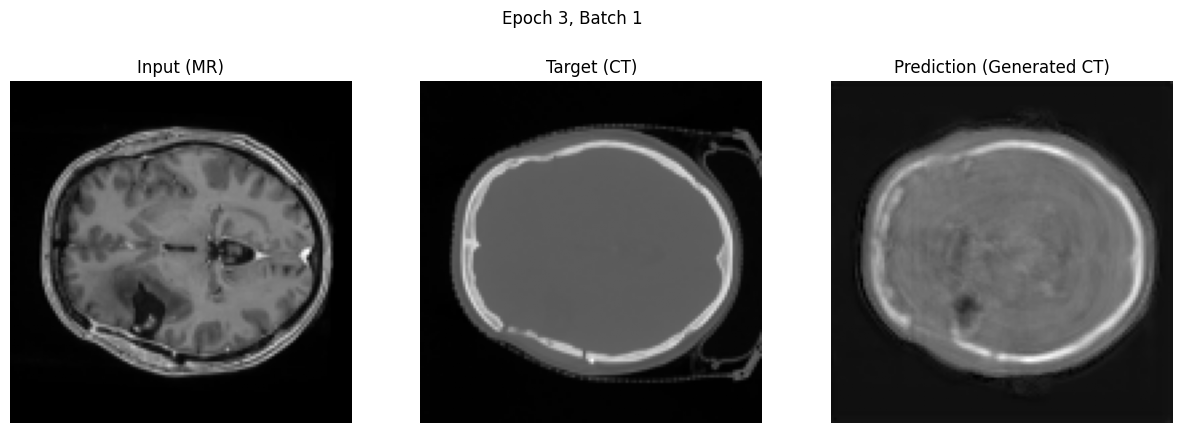

Epoch 4/10, Avg Train Loss: 0.1756130764408717
Epoch 4/10, Avg Validation Loss: 0.17032415952001298
EarlyStopping counter: 1 out of 5


Epoch 5/10: 100%|██████████| 63/63 [04:52<00:00,  4.65s/it, loss=0.193]


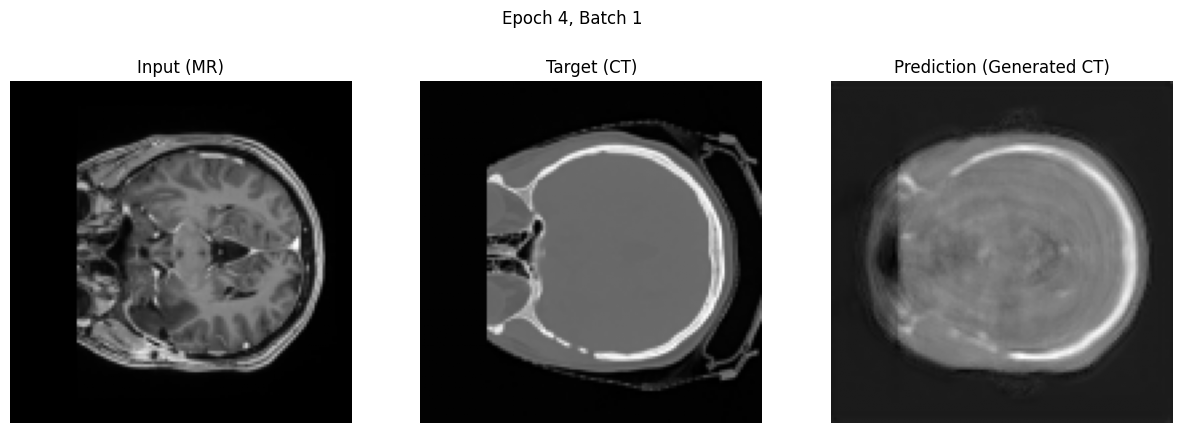

Epoch 5/10, Avg Train Loss: 0.17534744999711477
Epoch 5/10, Avg Validation Loss: 0.16988255189997808
EarlyStopping counter: 2 out of 5


Epoch 6/10: 100%|██████████| 63/63 [04:50<00:00,  4.61s/it, loss=0.142]


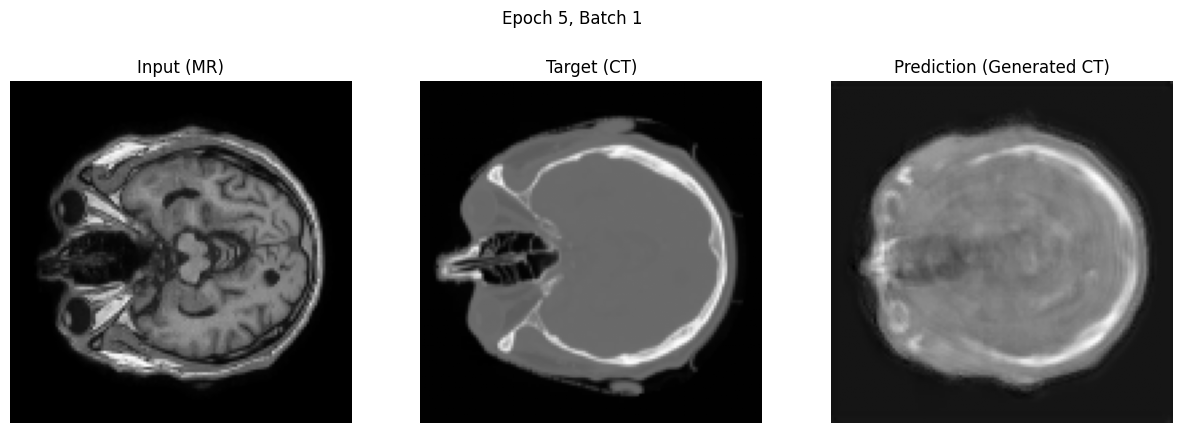

Epoch 6/10, Avg Train Loss: 0.1750434244435931
Epoch 6/10, Avg Validation Loss: 0.1690982441817011
Validation loss decreased (2.375601 --> 2.367375). Saving model...


Epoch 7/10: 100%|██████████| 63/63 [04:52<00:00,  4.65s/it, loss=0.15]


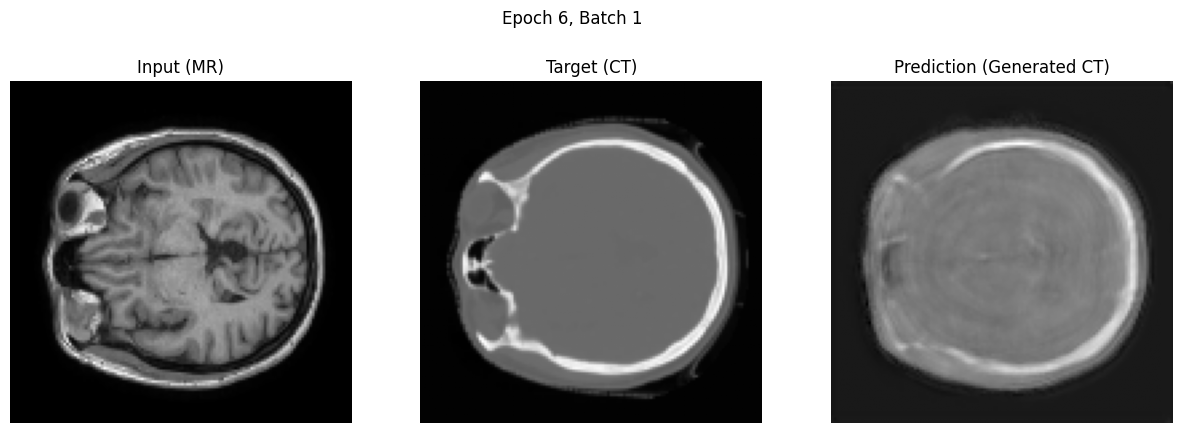

Epoch 7/10, Avg Train Loss: 0.1742486826011113
Epoch 7/10, Avg Validation Loss: 0.16908820079905645
Validation loss decreased (2.367375 --> 2.367235). Saving model...


Epoch 8/10: 100%|██████████| 63/63 [04:50<00:00,  4.62s/it, loss=0.154]


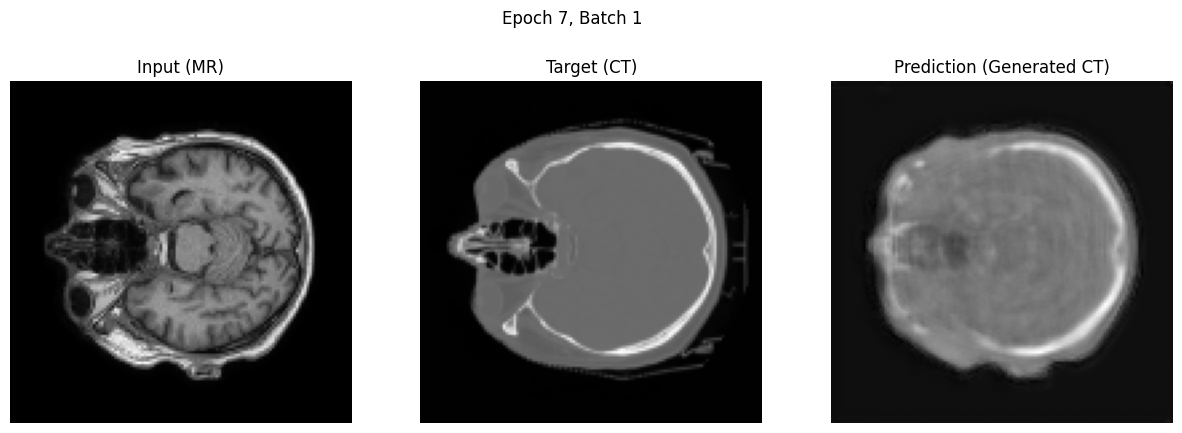

Epoch 8/10, Avg Train Loss: 0.1737796813249588
Epoch 8/10, Avg Validation Loss: 0.16836909843342646
Validation loss decreased (2.367235 --> 2.357167). Saving model...


Epoch 9/10: 100%|██████████| 63/63 [04:51<00:00,  4.62s/it, loss=0.137]


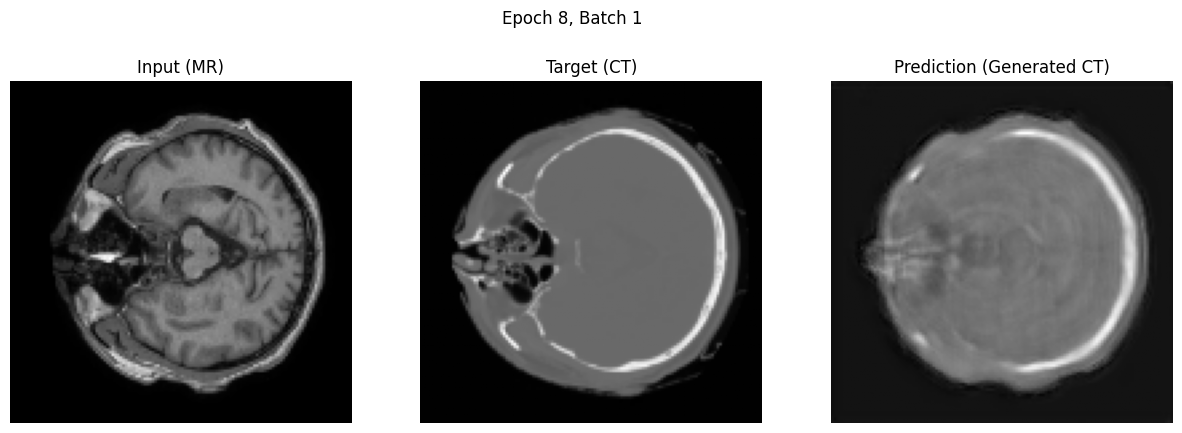

Epoch 9/10, Avg Train Loss: 0.1734996329224299
Epoch 9/10, Avg Validation Loss: 0.16764548314469202
Validation loss decreased (2.357167 --> 2.347037). Saving model...


Epoch 10/10: 100%|██████████| 63/63 [04:52<00:00,  4.65s/it, loss=0.161]


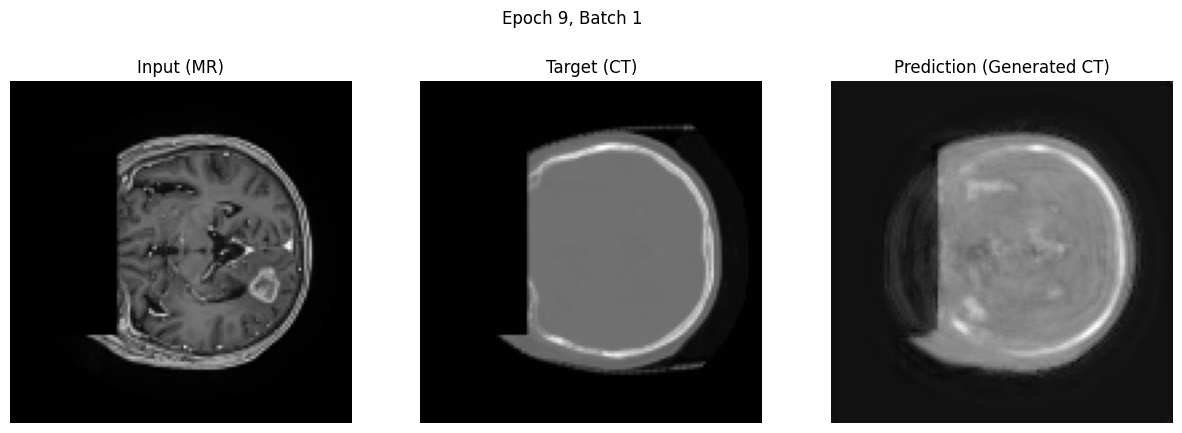

Epoch 10/10, Avg Train Loss: 0.1734417142376067
Epoch 10/10, Avg Validation Loss: 0.1673738041094371
Validation loss decreased (2.347037 --> 2.343233). Saving model...


<ipython-input-9-8e079cd91671>:83: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pt"))


<All keys matched successfully>

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 優化器與損失函數
optimizer = optim.Adam(model.parameters(), lr=0.000005)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)  # 學習率調整
criterion = nn.L1Loss()

# 訓練參數
epochs = 10
best_loss = float("inf")

train_path = "/content/split/train"
valid_path = "/content/split/validation"
test_path = "/content/split/test"

train_dataset = MRCTDataset(train_path)
valid_dataset = MRCTDataset(valid_path)
test_dataset = MRCTDataset(test_path)


train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=2)
val_loader = DataLoader(valid_dataset, batch_size=2, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, num_workers=2)

for mr, ct in train_loader:
    print(f"MR shape: {mr.shape}, CT shape: {ct.shape}")
    break

early_stopping = EarlyStopping(patience=5, verbose=True, path="best_model.pt")

for epoch in range(epochs):
    # 訓練階段
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
    for mr, ct in progress_bar:
        mr, ct = mr.to(device), ct.to(device)
        optimizer.zero_grad()
        output = model(mr)
        loss = criterion(output, ct)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())
    # if epoch % 5 == 0:  # 每 5 個 epoch 可視化一次
    #     visualize_results(mr, ct, output, epoch, idx=1)
    visualize_results(mr, ct, output, epoch, idx=1)

    avg_train_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{epochs}, Avg Train Loss: {avg_train_loss}")

    # 驗證階段
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for mr, ct in val_loader:
            mr, ct = mr.to(device), ct.to(device)
            output = model(mr)
            loss = criterion(output, ct)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    print(f"Epoch {epoch+1}/{epochs}, Avg Validation Loss: {avg_val_loss}")

    # 調用 EarlyStopping
    early_stopping(val_loss, model)

    # 如果觸發 EarlyStopping，結束訓練
    if early_stopping.early_stop:
        print("Early stopping triggered. Stopping training.")
        break

    #保存最佳模型
    # if avg_val_loss < best_loss:
    #     best_loss = avg_val_loss
    #     torch.save(model.state_dict(), "best_model.pth")
    #     print("Best model saved!")

    # scheduler.step()


model.load_state_dict(torch.load("best_model.pt"))